   # Math 495 Final Project

 ## <span style="color: purple;">Kordell Schrock & Clark Reimers</span>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpt
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("GameSales2016.csv") #import dataset
df.head()

 ## <span style="color: purple;">Clean the Data</span>

In [ ]:
df = df.dropna() #remove NA rows
df.info()

In [ ]:
df = df.sort_values(by=['Global_Sales'],ascending=False)
#for i in df.columns:
 #   sns.relplot(y=i,x='Global_Sales',data=df)

#plt.tight_layout()
#plt.show()

In [ ]:
#'User_Score' rows with 'tbd' values to be dropped
df = df.drop(df[df.User_Score == 'tbd'].index)
# Replace old videogame rating convention "K-A" with "E"
df['Rating']=df['Rating'].replace(['K-A'], 'E')
#Convert 'Year_of_Release' from float to integer
df['Year_of_Release']=df['Year_of_Release'].astype(int)
#Convert 'User_Score' from object to float
df['User_Score']=10*df['User_Score'].astype(float)
#rename column
df = df.rename(columns={"Year_of_Release": "Year"})
#calculate how old a Video Game is
df["Age"] = 2018 - df["Year"]
df.head()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
noObjects = df.select_dtypes(exclude=['object']) #remove objects
Xcols= noObjects.drop([], axis=1)
vif = pd.DataFrame()
vif["features"] = Xcols.columns
vif["vif_Factor"] = [variance_inflation_factor(Xcols.values, i) for i in range(Xcols.shape[1])]
print(vif) #vif Factor is helpful to find columns to remove since they are not good independent variables
#VIF factor under 10 is good for independent variables

In [ ]:
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu") #print the heat map
plt.show()

In [ ]:
scored = df.dropna(subset=["User_Score", "Critic_Score", "Rating"])
scored.describe()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
numeric_subset = scored.select_dtypes("number").drop(columns=["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Year"])

# Select the categorical column
categorical_subset = scored[["Platform", "Genre", "Rating"]]

# One hot encode
encoder = ce.one_hot.OneHotEncoder()
categorical_subset = encoder.fit_transform(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Find correlations with the score 
correlations = features.corr()["Global_Sales"].dropna().sort_values()

In [ ]:
correlations.head(5)

In [ ]:
correlations.tail(5)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

basic_target = pd.Series(features["Global_Sales"])
basic_features = features.drop(columns="Global_Sales")
features_train, features_test, target_train, target_test = train_test_split(basic_features, basic_target, 
                                                                            test_size=0.2,
                                                                            random_state=42)
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)


In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(features_train, target_train)
    
    # Make predictions and evalute
    model_pred = model.predict(features_test)
    model_mae = mae(target_test, model_pred)
    
    # Return the performance metric
    return model_mae

In [32]:
def mae(y_true, y_pred):
    return np.average(abs(y_true - y_pred))

In [33]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print("Linear Regression Performance on the test set: MAE = {:.04f}".format(lr_mae))
# Loss function to be optimized
loss = ["ls", "lad", "huber"]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ["auto", "sqrt", "log2", None]

hyperparameter_grid = {"loss": loss,
                       "max_depth": max_depth,
                       "min_samples_leaf": min_samples_leaf,
                       "min_samples_split": min_samples_split,
                       "max_features": max_features}

Linear Regression Performance on the test set: MAE = 0.7159


In [34]:
basic_model = GradientBoostingRegressor(random_state = 42)

random_cv = RandomizedSearchCV(estimator=basic_model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=20, 
                               scoring="neg_mean_absolute_error",
                               n_jobs=-1, verbose=1, 
                               return_train_score=True,
                               random_state=42)

In [35]:
random_cv.fit(features_train, target_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


RandomizedSearchCV(cv=4, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'loss': ['ls', 'lad', 'huber'],
                                        'max_depth': [2, 3, 5, 10, 15],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 4, 6, 10]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=1)

In [31]:
random_results = pd.DataFrame(random_cv.cv_results_).sort_values("mean_test_score", ascending=False)
random_results.head(10)[["mean_test_score", "param_loss",
                         "param_max_depth", "param_min_samples_leaf", "param_min_samples_split",
                         "param_max_features"]]

,mean_test_score,param_loss,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_max_features
0,-0.463182,huber,15,8,6,log2
7,-0.468981,huber,5,6,6,auto
17,-0.470044,lad,15,2,4,log2
1,-0.509264,huber,2,2,4,None
8,-0.510029,lad,2,4,10,auto
16,-0.514074,lad,3,1,10,log2
19,-0.524406,lad,2,1,10,sqrt
3,-0.525703,lad,2,8,10,sqrt
18,-0.531332,huber,2,8,6,sqrt
10,-0.531606,huber,2,1,2,sqrt


In [36]:
from sklearn.model_selection import GridSearchCV
trees_grid = {"n_estimators": [50, 100, 150, 200, 250, 300]}

basic_model = random_cv.best_estimator_
grid_search = GridSearchCV(estimator=basic_model, param_grid=trees_grid, cv=4, 
                           scoring="neg_mean_absolute_error", verbose=1,
                           n_jobs=-1, return_train_score=True)


In [37]:
grid_search.fit(features_train, target_train);


Fitting 4 folds for each of 6 candidates, totalling 24 fits


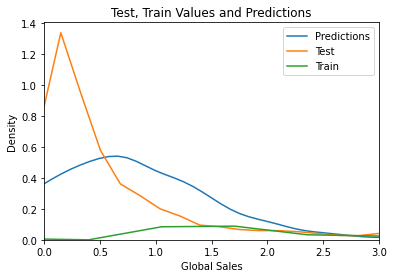

In [56]:
g = (sns.kdeplot(basic_final_pred, label = "Predictions").set(xlim=(0,3)))
sns.kdeplot(target_test, label = "Test")
sns.kdeplot(target_train, label = "Train")
#plt.set_xlim([0,2])
plt.xlabel("Global Sales"); plt.ylabel("Density");
plt.title("Test, Train Values and Predictions");

plt.show(g)

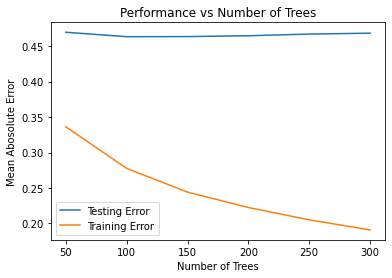

In [57]:
results = pd.DataFrame(grid_search.cv_results_)

plt.plot(results["param_n_estimators"], -1 * results["mean_test_score"], label = "Testing Error")
plt.plot(results["param_n_estimators"], -1 * results["mean_train_score"], label = "Training Error")
plt.xlabel("Number of Trees"); plt.ylabel("Mean Abosolute Error"); plt.legend();
plt.title("Performance vs Number of Trees");